In [62]:
import os
import sys
import json
import torch
import numpy as np

import scipy.io
import matplotlib
from scipy import ndimage
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':10,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
import PIL
from torch.utils import data

Global seed set to 42


In [3]:
def calc_pc_uniform_circle(npt=10001):
    theta = np.linspace(0,2*np.pi,npt,endpoint=False)
    radius = 0.25
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    pc = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))
    normals = pc/radius

    # shift the point cloud to centre of the domain
    pc = pc + 0.5

    # pt_cloud = []
    # for _ in range(1000):
    #     vec = np.random.randn(2)
    #     vec /= 4*np.linalg.norm(vec)
    #     pt_cloud.append(vec)
    # pt_cloud = np.array(pt_cloud)
    # self.normals = pt_cloud*4.0
    # self.pc = pt_cloud + 0.5
    return pc, normals

In [4]:
def im_io(filepath):
    image = io.imread(filepath).astype(bool).astype(float)
    

    return im2pc(image)

def im2pc(image, nx, ny):
    pc = []
    normals = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] == 1.0:
                boundary = 0
                if i < image.shape[0] - 1:
                    if image[i+1,j] == 0:
                        boundary = 1
                if j < image.shape[1] - 1:
                    if image[i,j+1] == 0:
                        boundary = 1
                if i > 0:
                    if image[i-1,j] == 0:
                        boundary = 1
                if j > 0:
                    if image[i,j-1] == 0:
                        boundary = 1
                if i < image.shape[0] - 1  and j < image.shape[1] - 1:
                    if image[i+1,j+1] == 0:
                        boundary = 1
                if i < image.shape[0] - 1  and j > 0:
                    if image[i+1,j-1] == 0:
                        boundary = 1
                if i > 0 and j < image.shape[1] - 1:
                    if image[i-1,j+1] == 0:
                        boundary = 1
                if i > 0 and j > 0:
                    if image[i-1,j-1] == 0:
                        boundary = 1
                if boundary == 1:
                    pc.append([i+0.5,j+0.5])
                    normals.append([nx[i,j]/(nx[i,j]**2 + ny[i,j]**2), ny[i,j]/(nx[i,j]**2 + ny[i,j]**2)])
    return np.array(pc), np.array(normals)

In [65]:
def plot_contours(self, u):
        fig, axs = plt.subplots(1, 3, figsize=(3.5*3,2.4),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        # error
        err = u - self.dataset.u_exact
        err = np.where(self.dataset.condition_arr, np.zeros_like(err), err)
        h = 1./self.domain_size
        errl2 = np.linalg.norm(err, 'fro')/self.domain_size
        errinf = np.max(err)
        im0 = axs[0].imshow(u,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(self.dataset.u_exact,cmap='jet')
        fig.colorbar(im1, ax=axs[1])  
        im = axs[2].imshow(err,cmap='jet')
        fig.colorbar(im, ax=axs[2])  
#         im0 = axs[0].contourf(self.dataset.x, self.dataset.y, u,cmap='jet')
#         fig.colorbar(im0, ax=axs[0])
#         im1 = axs[1].contourf(self.dataset.x, self.dataset.y, self.dataset.u_exact,cmap='jet')
#         fig.colorbar(im1, ax=axs[1])  
#         im = axs[2].contourf(self.dataset.x, self.dataset.y, err,cmap='jet')
#         fig.colorbar(im, ax=axs[2])  
#         plt.suptitle("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
        print("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
#         plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
#         self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
#         plt.close('all')

In [6]:
class PCVox(data.Dataset):
    'PyTorch dataset for PCVox'
    def __init__(self, filename, domain_size=128, **kwargs):
        """
        Initialization
        """
        file, ext = os.path.splitext(filename)
        if ext in ['.png', '.jpg', '.bmp', '.tiff']:
            img = PIL.Image.open(filename).convert('L')
            # img = PIL.Image.open(filename).convert('L').resize((700, 300))
            img = (np.asarray(img)>0).astype('float')
        else:
            raise ValueError('invalid extension; extension not supported')

        # Define kernel for x differences
        kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
        # Define kernel for y differences
        ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
        # Perform x convolution
        nx = ndimage.convolve(img,kx)
        # Perform y convolution
        ny = ndimage.convolve(img,ky)
        nx = np.divide(nx,(nx**2 + ny**2), out=np.zeros_like(nx), where=((nx**2 + ny**2)!=0))
        ny = np.divide(ny,(nx**2 + ny**2), out=np.zeros_like(ny), where=((nx**2 + ny**2)!=0))
        
        x = np.linspace(0, 1, domain_size)
        y = np.linspace(0, 1, domain_size)

        xx , yy = np.meshgrid(x, y)
        self.x = xx
        self.y = yy
        
        rdisk = 0.25
        self.condition_arr = ((xx-0.5)**2+(yy-0.5)**2) > rdisk**2
        
        self.u_exact = (rdisk**2-((xx-0.5)**2+(yy-0.5)**2))/4.
        self.u_exact = np.where(self.condition_arr, np.zeros_like(xx), self.u_exact)
        # bc1 for outer boundary
        self.bc1 = np.zeros_like(xx)
        self.bc1 = np.where(self.condition_arr, 1., self.bc1)
        
        self.forcing = np.ones_like(xx)
#         self.forcing = np.where(condition_arr, 0., self.forcing)

        # bc1 will be source, sdf will be set to 0.5 at these locations
#         self.pc, self.normals = im2pc(img,nx,ny)
#         self.pc = self.pc/(img.shape[0])
        npt_circle = kwargs.get('npt_circle', 10001)
        self.pc, self.normals = calc_pc_uniform_circle(npt_circle)
        
        self.domain = np.ones((domain_size,domain_size))
        self.domain_size = domain_size
        self.n_samples = 100

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = np.array([self.pc, self.normals]) # 2, Npoint, 2
        #forcing = np.ones_like(self.domain)
        forcing = self.forcing
        return torch.FloatTensor(inputs), torch.FloatTensor(forcing).unsqueeze(0)

In [7]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        pc = inputs_tensor[:,0:1,:,:]
        normals = inputs_tensor[:,1:2,:,:]
        bc1 = torch.FloatTensor(self.dataset.bc1).unsqueeze(0).unsqueeze(0).type_as(u)
        
#         u = torch.where(bc1>0.5,torch.zeros_like(u),u)
        
#         if self.current_epoch == 3:
#             plt.imshow(u.squeeze().detach().cpu().numpy())
#             plt.colorbar()
#             plt.show()
#             return
        
        # init bin widths
        hx = self.h
        hy = self.h

        # apply boundary conditions
        nidx = (pc[:,:,:,0]/self.hx).type(torch.LongTensor).to(pc.device)
        nidy = (pc[:,:,:,1]/self.hy).type(torch.LongTensor).to(pc.device)

        u_pts_grid =  torch.stack([
                torch.stack([
                    torch.stack([u[b,0,nidx[b,0,:],nidy[b,0,:]] for b in range(u.size(0))]),
                    torch.stack([u[b,0,nidx[b,0,:]+1,nidy[b,0,:]] for b in range(u.size(0))])]),
                torch.stack([
                    torch.stack([u[b,0,nidx[b,0,:],nidy[b,0,:]+1] for b in range(u.size(0))]),
                    torch.stack([u[b,0,nidx[b,0,:]+1,nidy[b,0,:]+1] for b in range(u.size(0))])])
                ]).unsqueeze(2)

        x_pts = pc[:,:,:,0] - nidx.type_as(pc)*self.hx 
        y_pts = pc[:,:,:,1] - nidy.type_as(pc)*self.hy

        xi_pts = (x_pts*2)/self.hx - 1
        eta_pts = (y_pts*2)/self.hy - 1

        # print(xi_pts, eta_pts)

        N_values_pts = self.bf_1d_th(xi_pts).unsqueeze(0)*self.bf_1d_th(eta_pts).unsqueeze(1)
        dN_x_values_pts = self.bf_1d_der_th(xi_pts).unsqueeze(0)*self.bf_1d_th(eta_pts).unsqueeze(1)
        dN_y_values_pts = self.bf_1d_th(xi_pts).unsqueeze(0)*self.bf_1d_der_th(eta_pts).unsqueeze(1)

        u_pts = torch.sum(torch.sum(N_values_pts*u_pts_grid,0),0)
        u_x_pts = torch.sum(torch.sum(dN_x_values_pts*u_pts_grid,0),0)
        u_y_pts = torch.sum(torch.sum(dN_y_values_pts*u_pts_grid,0),0)

        # nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(f)
        res_elmwise = transformation_jacobian * (0.5 * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        res_elmwise = torch.sum(res_elmwise, 1)

        loss = torch.mean(res_elmwise) + torch.sum((u_pts-0.0)**2)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        return self.network[0], inputs_tensor, forcing_tensor

    def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        self.log('PDE_loss', loss.item())
        self.log('loss', loss.item())
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate
        opts = [torch.optim.LBFGS(self.network, lr=1.0, max_iter=5)]
        # opts = [torch.optim.Adam(self.network, lr=lr)]
        return opts, []

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u = self.do_query(inputs, forcing)
        self.plot_contours(u.squeeze().detach().cpu())

    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), forcing.unsqueeze(0).type_as(next(self.network.parameters()))))

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        # nu = inputs_tensor[:,0:1,:,:]
        # bc1 = inputs_tensor[:,1:2,:,:]
        # bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        # u = torch.where(bc1>0.5,1.0+u*0.0,u)
        # u = torch.where(bc2>0.5,u*0.0,u)

        # nu = nu.squeeze().detach().cpu()
        # u = u.squeeze().detach().cpu()
        bc1 = torch.FloatTensor(self.dataset.bc1).unsqueeze(0).unsqueeze(0).type_as(u)
        u = torch.where(bc1>0.5,torch.zeros_like(u),u)

        return u

    def plot_contours(self, u):
        fig, axs = plt.subplots(1, 3, figsize=(2*3,1.2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        # error
        err = u - self.dataset.u_exact
        err = np.where(self.dataset.condition_arr, np.zeros_like(err), err)
        h = 1./self.domain_size
        errl2 = np.linalg.norm(err, 'fro')/self.domain_size
        errinf = np.max(err)
        im0 = axs[0].imshow(u,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(self.dataset.u_exact,cmap='jet')
        fig.colorbar(im1, ax=axs[1])  
        im = axs[2].imshow(err,cmap='jet')
        fig.colorbar(im, ax=axs[2])  
        plt.suptitle("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all')

In [8]:
domain_size = 128
npt_circle = 5001
filename = 'bunny-18.png'
dataset = PCVox(filename, domain_size=domain_size, npt_circle=npt_circle)
u_tensor = np.ones((1,1,domain_size,domain_size))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
basecase = Poisson(network, dataset, batch_size=1, domain_size=domain_size)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="pc_poisson_disk")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=5, deterministic=True, profiler='simple')

/work/baskarg/bkhara/python_virtual_envs/py-3.7.7-b5s6jni/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x2b13b0683c10>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x2b13b0683c10>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [10]:
# ------------------------
# 4 Training
# ------------------------

trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 16.4 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
-----------------------------------------------
16.4 K    Trainable params
108       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/work/baskarg/bkhara/python_virtual_envs/py-3.7.7-b5s6jni/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of th

Training: 0it [00:00, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  66.79          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  8.3803         	|5              	|  41.901         	|  62.736         	|
run_training_batch                 	|  0.078787       	|500            	|  39.394         	|  58.982         	|
optimizer_step_with_closure_0      	|  0.078591       	|500            	|  39.296         	|  58.835         	|
training_step_and_backward         	|  0.007091       	|2496           	|  17.699         	|  26.5           	|
model_forward                      

h = 0.007812, el2 = 0.000132, el_inf = 0.000112


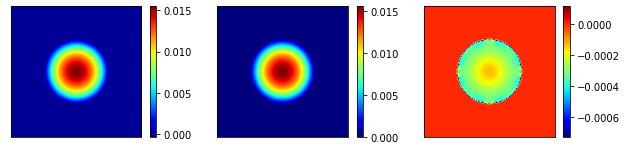

In [66]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u = basecase.do_query(inputs, forcing)
u = u.squeeze().detach().numpy()

# plot
plot_contours(basecase, u)

In [360]:
# error
err = u - dataset.u_exact
err = np.where(dataset.condition_arr, np.zeros_like(err), err)
h = 1./domain_size
errl2 = np.linalg.norm(err, 'fro')/domain_size
errinf = np.max(err)
print(errl2, errinf)

0.0001645374642882379 0.00011153767707236181


In [361]:
narr = np.array([32,64,128,256,300,400,512])
harr = 1./(narr-1)
earr = np.array([0.0004439346, 0.000243,0.000165,0.000083,5.60983477886956e-05,2.0218241155234025e-05,5.380315759714331e-06])

In [12]:
narr = np.array([32,64,128,256,512])
harr = 1./(narr-1)
earr = np.array([0.0004439346, 0.000243,0.000165,0.000083,5.380315759714331e-06])

In [73]:
comb = np.stack((narr,harr,earr))

In [74]:
comb.T

array([[3.20000000e+01, 3.22580645e-02, 4.43934600e-04],
       [6.40000000e+01, 1.58730159e-02, 2.43000000e-04],
       [1.28000000e+02, 7.87401575e-03, 1.65000000e-04],
       [2.56000000e+02, 3.92156863e-03, 8.30000000e-05],
       [5.12000000e+02, 1.95694716e-03, 5.38031576e-06]])

In [13]:
np.polyfit(np.log(harr[0:4]), np.log(earr[0:4]), 1)

array([ 0.77135295, -5.07325853])

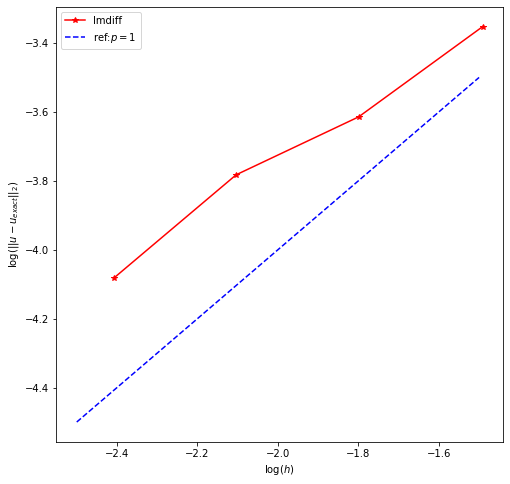

In [29]:
t = np.linspace(-2.5,-1.5,50)
ref1 = 1*t-2
ref2 = 2*t-1
plt.figure(figsize=(8,8))
plt.plot(np.log10(harr[0:4]), np.log10(earr[0:4]),'r*-', label='Imdiff')
plt.plot(t,ref1,'b--', label=r'ref:$p=1$')
# plt.plot(t,ref2,'k--', label=r'ref:$p=2$')
plt.xlabel("log($h$)")
plt.ylabel(r"$\log(||u-u_{exact}||_2)$")
plt.legend()

In [380]:
t = np.linspace()
plt.loglog((harr[0:4]), (earr[0:4]),'*-')

TypeError: _linspace_dispatcher() missing 2 required positional arguments: 'start' and 'stop'

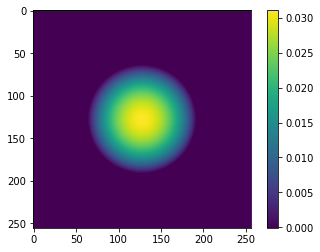

In [202]:
plt.imshow(err)
plt.colorbar()

In [184]:
u_non_mask = u

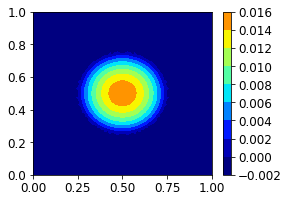

In [47]:
plt.figure(figsize=(4,3))
plt.contourf(dataset.x, dataset.y, u, vmin=0,vmax=0.02, cmap='jet')
plt.colorbar()

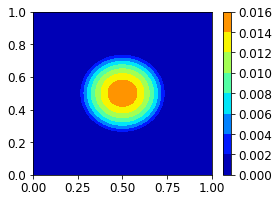

In [48]:
plt.figure(figsize=(4,3))
plt.contourf(dataset.x, dataset.y, dataset.u_exact, vmin=0,vmax=0.02, cmap='jet')
plt.colorbar()

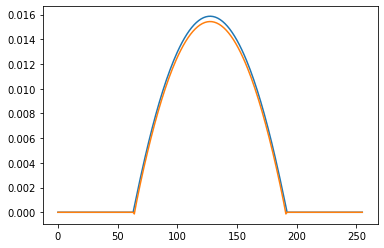

In [186]:
plt.plot(u_mask[:,128])
plt.plot(u_non_mask[:,128])

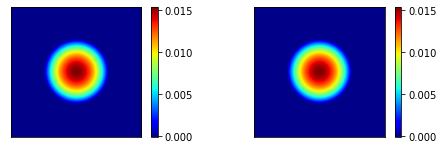

In [187]:
u_mask = u
plot_contours(basecase, u)

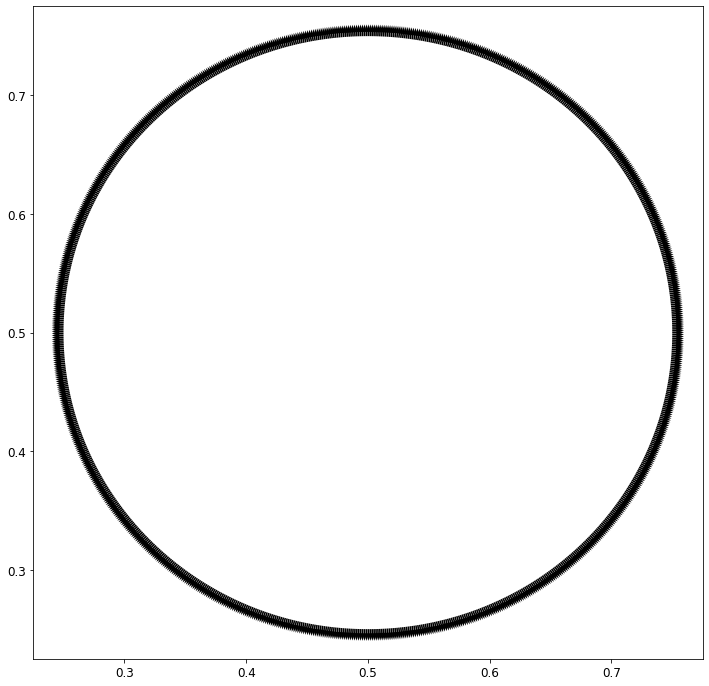

In [353]:
pc = dataset.pc
normals = dataset.normals

plt.figure(figsize=(12,12))
plt.quiver(pc[:,0],pc[:,1], normals[:,0], normals[:,1])

In [61]:
    theta = np.linspace(0,2*np.pi,101,endpoint=False)
    radius = 0.25
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    pc = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))
    normals = pc/radius

    # shift the point cloud to centre of the domain
    pc = pc + 0.5

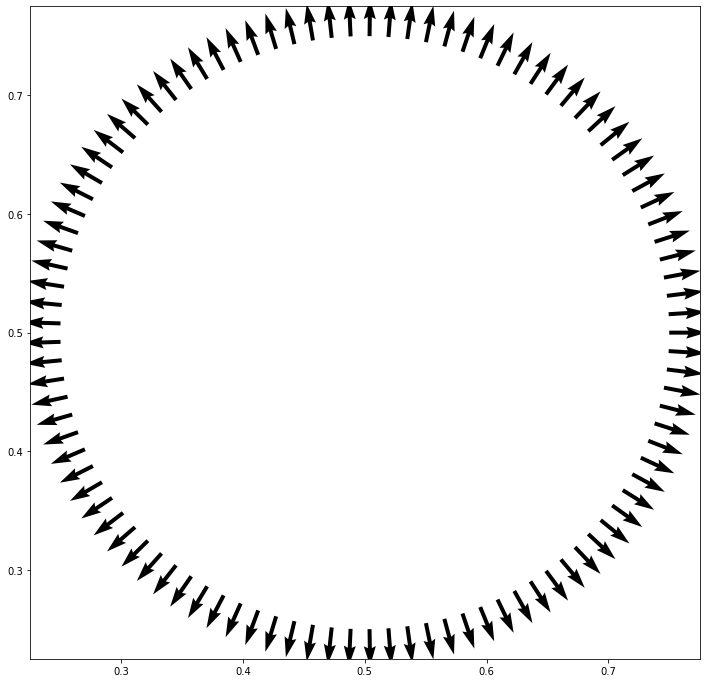

In [62]:
plt.figure(figsize=(12,12))
plt.quiver(pc[:,0],pc[:,1], normals[:,0], normals[:,1])

In [57]:
pc

array([[0.74084341, 0.43295934],
       [0.59783644, 0.73006093],
       [0.32321711, 0.3232295 ],
       [0.7248553 , 0.60927075],
       [0.33641552, 0.68905057]])

In [49]:
normals

array([[ 0.96337365, -0.26816265],
       [ 0.39134578,  0.92024371],
       [-0.70713157, -0.70708199],
       [ 0.89942118,  0.43708299],
       [-0.65433791,  0.75620229]])

In [51]:
np.max(dataset.pc)

0.7499963724419908

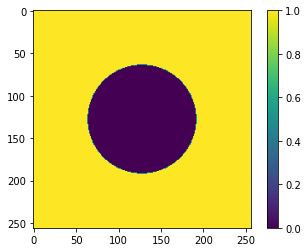

In [116]:
plt.imshow(dataset.bc1)
plt.colorbar()

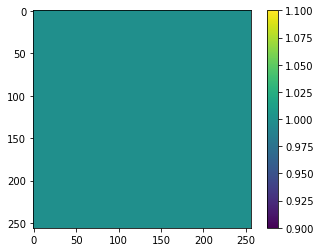

In [118]:
plt.imshow(dataset.forcing)
plt.colorbar()

In [75]:
u.shape

(128, 128)